### Import data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")

from utils.data_loader import *
from config.config_KR import *

### Load Data

In [2]:
target_df = load_target_data(TARGET_PATH)
df = load_feature_data(FEATURE_PATH, FEATURE_COLUMN, TRAIN_DATE)

df = df.shift(FORECAST_HORIZON) # Bring Past data of explanatory variables and predict the future
for col in target_df.columns:
    df[f'{col}_lag{FORECAST_HORIZON}'] = target_df[col].shift(FORECAST_HORIZON)

df = pd.concat([df,target_df], axis = 1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

### Train and forecast

Best Penalty Weight: 1.6876124757881479 with Minimum MSE: 0.09756552053107978
Seoul


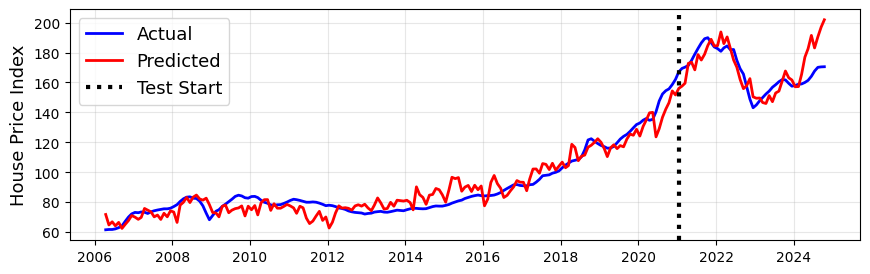

Best Penalty Weight: 1.2328467394420661 with Minimum MSE: 0.03703018380382298
Busan


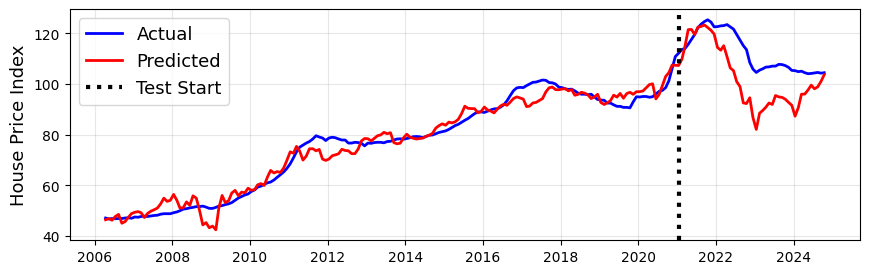

Best Penalty Weight: 2.848035868435802 with Minimum MSE: 0.03744329600763191
Daegu


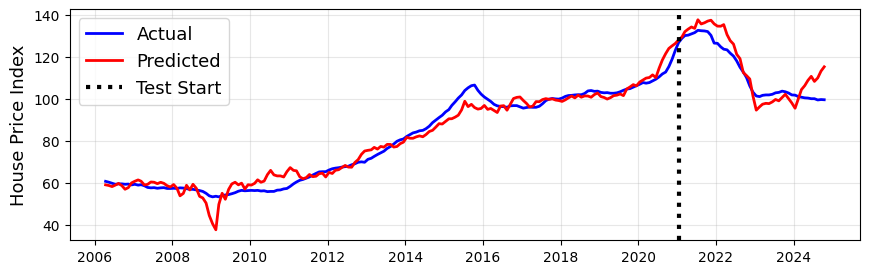

Best Penalty Weight: 1.368874509537081 with Minimum MSE: 0.2378689581245999
Incheon


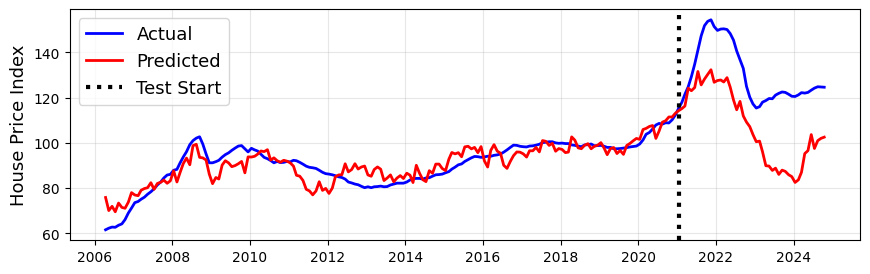

Best Penalty Weight: 1.368874509537081 with Minimum MSE: 0.02257891284271187
Gwangju


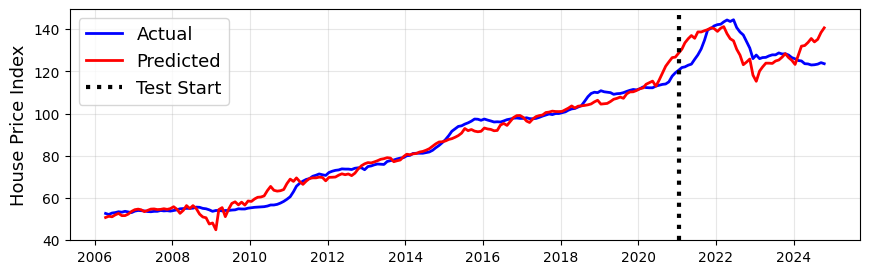

Best Penalty Weight: 1.5199110829529336 with Minimum MSE: 0.13128998954567164
Daejeon


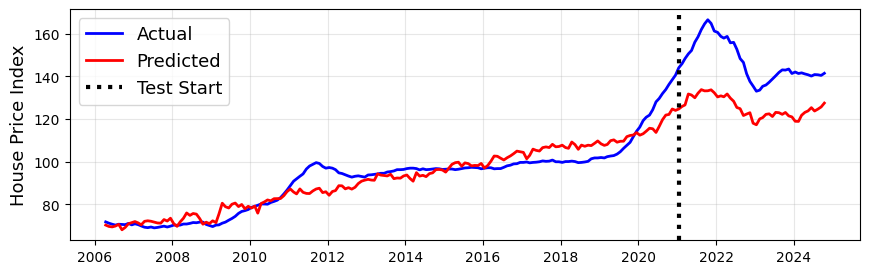

Best Penalty Weight: 2.3101297000831598 with Minimum MSE: 0.17500813109518032
Ulsan


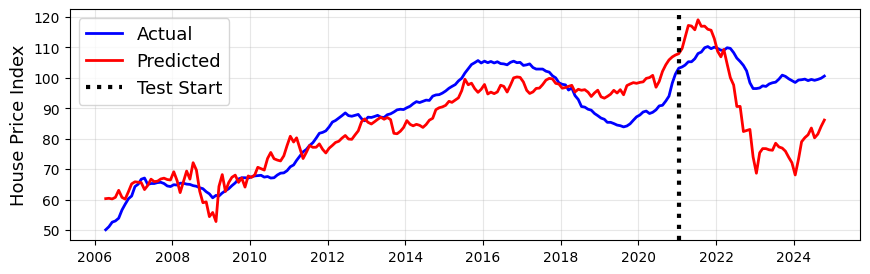

Best Penalty Weight: 1.110336318167638 with Minimum MSE: 0.17593166859020035
Sejong


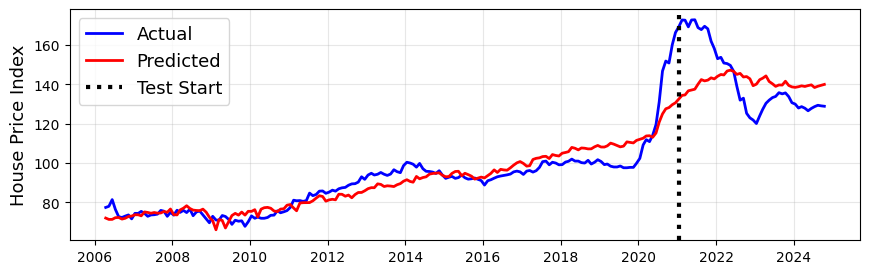

Best Penalty Weight: 2.3101297000831598 with Minimum MSE: 0.1899050237057919
Gyeonggi


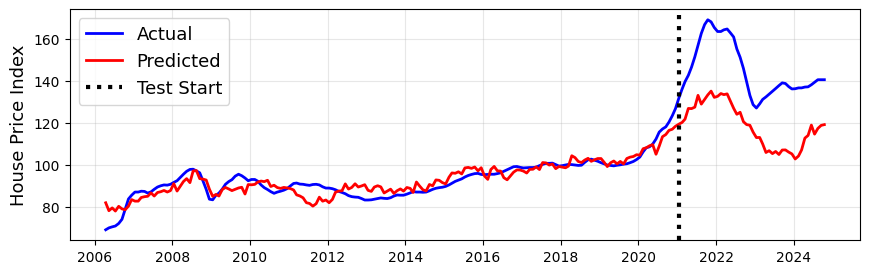

Best Penalty Weight: 1.0 with Minimum MSE: 0.08480601896169161
Gangwon


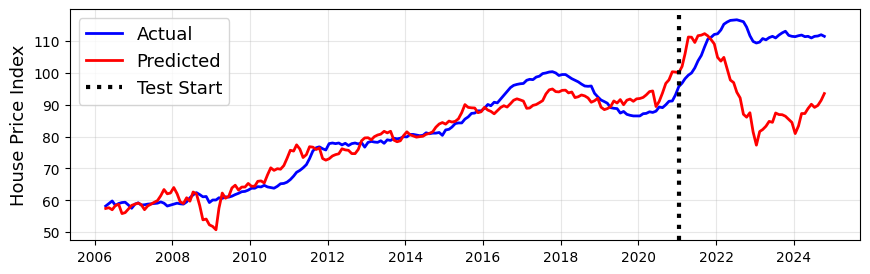

Best Penalty Weight: 2.0805675382171707 with Minimum MSE: 0.3237105288230029
Chungbuk


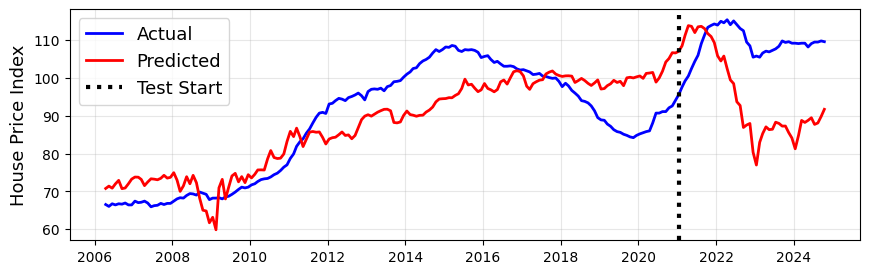

Best Penalty Weight: 3.1622776601683795 with Minimum MSE: 0.3735731876890287
Chungnam


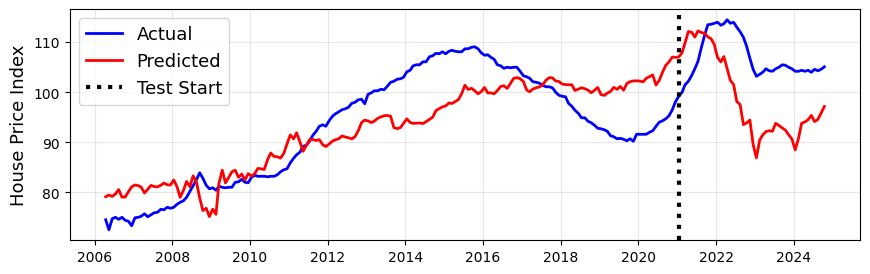

Best Penalty Weight: 2.3101297000831598 with Minimum MSE: 0.22914959978957336
Jeonbuk


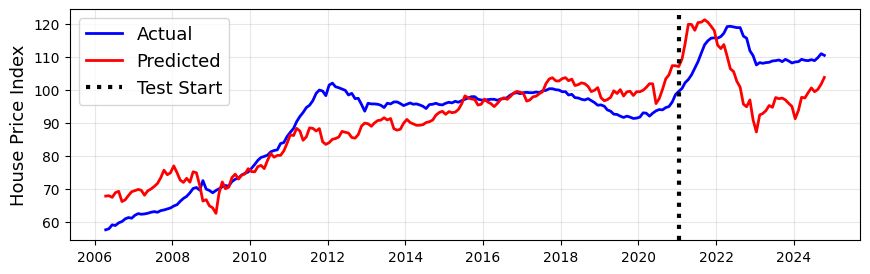

Best Penalty Weight: 2.3101297000831598 with Minimum MSE: 0.06946546811084348
Jeonnam


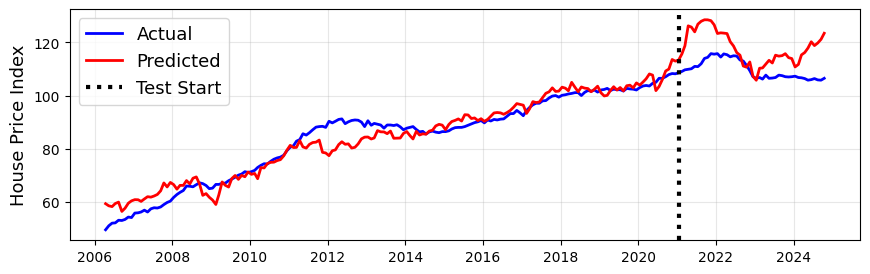

Best Penalty Weight: 2.0805675382171707 with Minimum MSE: 0.352883064045543
Gyeongbuk


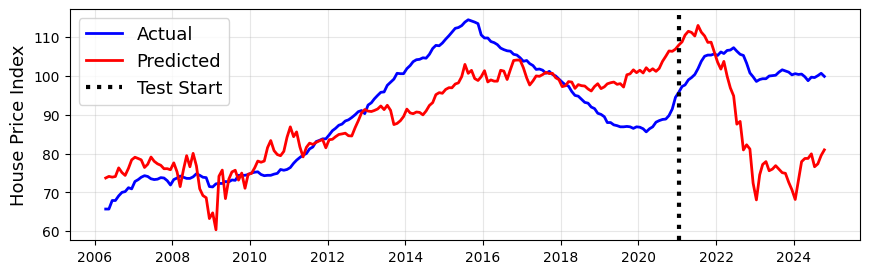

Best Penalty Weight: 15.199110829529339 with Minimum MSE: 0.3734307707150389
Gyeongnam


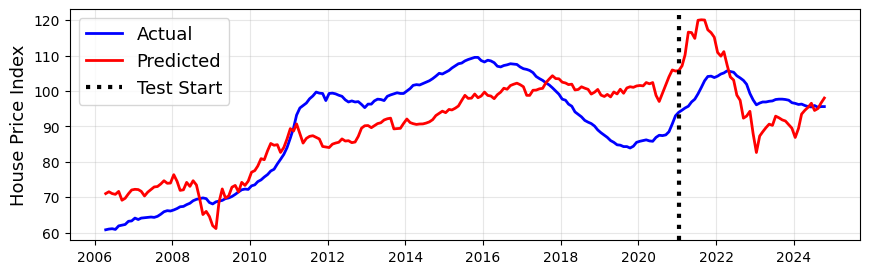

Best Penalty Weight: 2.848035868435802 with Minimum MSE: 0.07648311872604475
Jeju


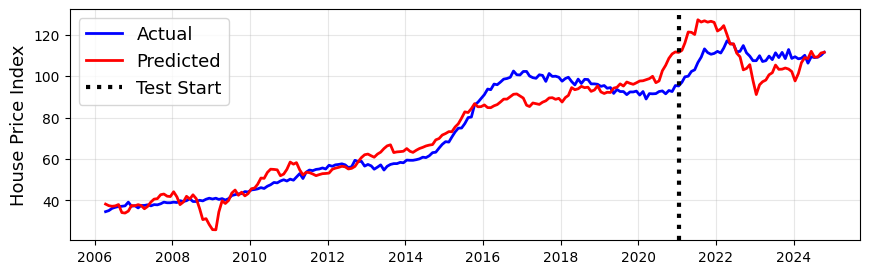

In [7]:
model_name = "Penalty_LM_No_y"
dir_path = f"/Users/yeojisu/Documents/HPI-Save/Korea/Baseline/traditional/{FORECAST_SIZE}_{model_name}.csv"

def loss_function(coeffs, X, y, signs, penalty_weight=100):
    predictions = X.dot(coeffs[:-1]) + coeffs[-1]
    mse = ((predictions - y) ** 2).mean()
    
    # Apply penalty only if there is a sign constraint (penalty is applied when signs != 0)
    penalties = penalty_weight * np.abs(coeffs[:-1]) * ((np.sign(coeffs[:-1]) != signs) & (signs != 0))
    return mse + penalties.sum()

for target in target_df.columns:
    x_df = df[FEATURE_COLUMN] # no y
    y_df = df[target]

    # Split Train and Test Data
    X_train, X_test, y_train, y_test = x_df[x_df.index<TEST_DATE], x_df[x_df.index>=TEST_DATE], y_df[y_df.index<TEST_DATE], y_df[y_df.index>=TEST_DATE]

    # Scaling
    x_df_mu, x_df_std = X_train.mean(), X_train.std()
    y_df_mu, y_df_std = y_train.mean(), y_train.std()

    X_train = z_transform(X_train, x_df_mu, x_df_std)
    X_test = z_transform(X_test, x_df_mu, x_df_std)
    y_train = z_transform(y_train, y_df_mu, y_df_std)
    y_test = z_transform(y_test, y_df_mu, y_df_std)

    df_train_inv = pd.concat([pd.DataFrame(y_train), X_train], axis=1)
    df_test_inv = pd.concat([pd.DataFrame(y_test), X_test], axis=1)
    
    initial_coeffs = np.zeros(X_train.shape[1] + 1)
    variable_signs = np.array([
        -1,-1,-1, # Interest rate
        1,1,1, # Stock
        1,1,1, # Money supply, Liquidity
        -1,-1, # Inflation, Exchange rate
        1, # GDP
        -1,-1,# Construction
        #0 # Target -> No any sign constraint
       ])
    
    min_mse = float('inf')
    best_penalty_weight = None

    # Search for the best penalty weight
    for exponent in np.linspace(0, 2, 45):  # logarithmic scale search for penalty weights between 1 and 100
        penalty_weight = 10 ** exponent
        result = minimize(loss_function, initial_coeffs, args=(X_train, y_train, variable_signs, penalty_weight),
                        method='SLSQP', options={'maxiter': 10000, 'ftol': 1e-9})
        coeff_signs = np.sign(result.x[:-1])
        sign_check = np.all((coeff_signs == variable_signs) | (variable_signs == 0))
        mse = loss_function(result.x, X_train, y_train, variable_signs, 0)

        if sign_check and mse < min_mse:
            min_mse = mse
            optimized_coeffs = result.x[:-1]
            intercept = result.x[-1]
            best_penalty_weight = penalty_weight
            # Early stopping if MSE is very low
            if mse < 0.01:
                break
    if best_penalty_weight is not None:
        print(f"Best Penalty Weight: {best_penalty_weight} with Minimum MSE: {min_mse}")
    else:
        print("No solution found that satisfies all sign conditions.")

    # Perform prediction using optimized coefficients
    pred_train = inv_z_transform(X_train.dot(optimized_coeffs) + intercept, y_df_mu, y_df_std) 
    real_train = inv_z_transform(y_train, y_df_mu, y_df_std)
    
    pred = inv_z_transform(X_test.dot(optimized_coeffs) + intercept, y_df_mu, y_df_std) 
    real = inv_z_transform(y_test, y_df_mu, y_df_std) 
    
    rmse = round(mean_squared_error(real, pred)**0.5,3)
    mae = round(mean_absolute_error(real, pred),3)
    val =[target.split("_")[0],rmse,mae]
    
    # pd.DataFrame(val).T.to_csv(dir_path, mode='a', header=False, index=False)
    
    plt.figure(figsize=(10.2,3))
    print(f"{target.split('_')[0]}")
    # plt.title(f"{target.split('_')[0]} Actual VS Predicted")
    plt.plot(pd.to_datetime(df.index),pd.concat([real_train,real]),c='b',label="Actual",linewidth="2")
    plt.plot(pd.to_datetime(df.index),pd.concat([pred_train,pred]),c='r',label="Predicted",linewidth="2")
    plt.axvline(x=pd.to_datetime(y_test.index[0]), color='black', linestyle=':', linewidth=3, label="Test Start")
    plt.ylabel("House Price Index", fontsize=13)
    plt.legend(loc="upper left",fontsize=13)
    plt.grid(True, linestyle="-", alpha=0.3)
    plt.show()
    